# Digital Musicology (DH-401)
## Assignment 3: Similarity
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

In [200]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy import signal, interpolate
pd.set_option('display.max_rows', 500)

## 0. Dataset preparation

In [15]:
%%time

# Suppress SettingWithCopy warnings
pd.options.mode.chained_assignment = None

# Import CSV
chorales_dataset = pd.read_csv('DM 2022 - Assignment 3 [Dataset].csv', converters = {'mn_onset': fractions.Fraction, 'act_dur': fractions.Fraction, 'duration': fractions.Fraction, 'nominal_duration': fractions.Fraction, 'scalar': fractions.Fraction}, index_col = 0, low_memory = False)

## Add global onset column for easy time series manipulations (in units of whole notes)
# Sort accordingly
chorales_dataset = chorales_dataset.sort_values(by=['piece', 'staff', 'mn', 'mn_onset'])
# Shift duration column by 1
chorales_dataset['_shift_dur'] = np.roll(chorales_dataset['duration'], 1)
# Get invalid first shifts that will be removed
chorales_dataset['_first_shift'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform('first')
# Cumulate shifted durations
chorales_dataset['_cum_dur_uncleaned'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform(pd.Series.cumsum)
# Subtract invalid first shifts
chorales_dataset['global_onset'] = (chorales_dataset['_cum_dur_uncleaned'] - chorales_dataset['_first_shift'])
# Remove temp coliumns
chorales_dataset = chorales_dataset.drop(columns = ['_shift_dur','_first_shift','_cum_dur_uncleaned'])

# Ignore gracenotes (there is only one)
chorales_dataset = chorales_dataset[chorales_dataset['gracenote'].isna()].drop(columns = ['gracenote'])

# Remove Chorale043 because it is corrupted (it does not open in MuseScore, it does not include a closing fermata, and it has only 1 staff)
chorales_dataset = chorales_dataset[chorales_dataset['piece'] != 'BachChorales/Chorale043']

# Get unique piece/staff pairs
piece_staffs = chorales_dataset.groupby('piece')['staff'].unique().to_dict()

# Consider only until the fermata in or after the 4th bar
fermata_data = []
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        for idx, row in chorales_dataset[(chorales_dataset['piece'] == piece) & (chorales_dataset['staff'] == staff)].iterrows():
            fermata_data.append(row)
            if row['fermata'] and row['mn'] >= 4:
                break
fermata_df = pd.DataFrame(fermata_data)

# Sort by onset and staff for consistent alignment
fermata_df = fermata_df.sort_values(by=['piece', 'mn', 'mn_onset', 'staff']).reset_index(drop=True)

# Create dictionaries of last onsets, total piece durations, and smallest notes in each piece for future use
last_piece_onsets = fermata_df.groupby('piece')['global_onset'].max().apply(float).to_dict()
total_piece_durations = fermata_df.groupby(['piece','staff'])['duration'].sum().groupby('piece').max().apply(float).to_dict()
minimum_note_durations = fermata_df.groupby('piece')['duration'].min().apply(float).to_dict()

CPU times: user 19 s, sys: 531 ms, total: 19.6 s
Wall time: 22 s


In [11]:
# Display dataframe for random piece up to desired fermata
random_piece = fermata_df['piece'].sample(n=1).item()
random_piece_df = fermata_df[(fermata_df['piece'] == random_piece)]
random_piece_df

,piece,mn,mn_onset,timesig,act_dur,staff,voice,duration,nominal_duration,scalar,tied,tpc,midi,fermata,global_onset
4996,BachChorales/Chorale070,0,3/4,4/4,1/4,1,1,1/4,1/4,1,NaN,1,67,False,0
4997,BachChorales/Chorale070,0,3/4,4/4,1/4,2,1,1/4,1/4,1,NaN,2,62,False,0
4998,BachChorales/Chorale070,0,3/4,4/4,1/4,3,1,1/8,1/8,1,NaN,5,59,False,0
4999,BachChorales/Chorale070,0,3/4,4/4,1/4,4,1,1/8,1/8,1,NaN,1,43,False,0
5000,BachChorales/Chorale070,0,7/8,4/4,1/4,3,1,1/8,1/8,1,NaN,0,60,False,1/8
5001,BachChorales/Chorale070,0,7/8,4/4,1/4,4,1,1/8,1/8,1,NaN,3,45,False,1/8
5002,BachChorales/Chorale070,1,0,4/4,1,1,1,1/4,1/4,1,NaN,1,67,False,1/4
5003,BachChorales/Chorale070,1,0,4/4,1,2,1,1/8,1/8,1,NaN,1,67,False,1/4
5004,BachChorales/Chorale070,1,0,4/4,1,3,1,1/4,1/4,1,NaN,2,62,False,1/4
5005,BachChorales/Chorale070,1,0,4/4,1,4,1,1/4,1/4,1,NaN,5,47,False,1/4


## I. Similarity parameters
### a. Rhythm

In [16]:
%%time

# Sum durations of notes in each sampling bin
summed_durations_dict = {}
# Loop
for piece in piece_staffs.keys():
    piece_df = fermata_df[fermata_df['piece'] == piece]

    last_onset = last_piece_onsets[piece]
    sampling_period = minimum_note_durations[piece]

    bins = np.arange(0, (last_onset+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_df['global_onset'], bins, right = True)
    summed_durations_dict[piece] = piece_df.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 5.24 s, sys: 133 ms, total: 5.37 s
Wall time: 6.12 s


### b. Melodic contour

In [316]:
%%time

# Create dictionary of frontfilled pitches for each piece and staff in each sampling bin
piece_staff_pitches_dict = {}
# Loop
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        piece_staff_df = fermata_df[(fermata_df['piece'] == piece) & (fermata_df['staff'] == staff)]

        total_duration = total_piece_durations[piece]
        sampling_period = minimum_note_durations[piece]
        
        # Create equally spaced and normalized bins sampled by minimum note resolution
        bins = np.arange(0, total_duration+1e-10, sampling_period)
        binned_onsets = pd.cut(piece_staff_df['global_onset'], bins, right = False)
        # Front fill midi values as long as the onset lasts  
        piece_staff_pitches_dict[(piece,staff)] = piece_staff_df.groupby(binned_onsets)['midi'].first().ffill()

# Get mean pitches for each piece
# This is done by calculating the sum of pitches across staves and dividing by the number of staves
mean_pitches_dict = {}
for piece in piece_staffs.keys():
    cumsum = 0
    for staff in piece_staffs[piece]:
        cumsum += piece_staff_pitches_dict[(piece,staff)]
    mean_pitches_dict[piece] = cumsum / staff

# Manipulate data to get time series vs. pitches for each piece
melodic_contours = {}
for piece in piece_staffs.keys():
    time_steps = np.arange(0, total_piece_durations[piece]+1e-10, minimum_note_durations[piece])
    pitches = mean_pitches_dict[piece].values
    # Front fill up to final normalized duration
    pitches = np.append(pitches, pitches[-1])
    melodic_contours[piece] = (time_steps,pitches)

CPU times: user 1min 1s, sys: 1.99 s, total: 1min 3s
Wall time: 1min 11s


In [356]:
# Plot melodic contour of a random piece
random_piece = fermata_df['piece'].sample(n=1).item()

time_steps = melodic_contours[random_piece][0]
pitches = melodic_contours[random_piece][1]

time_steps_r = np.arange(0, 100, 1)
res = signal.resample(pitches, num=100)

f = interpolate.interp1d(time_steps, pitches, kind='zero')
xnew = np.arange(0, max(time_steps), max(time_steps)/100)
ynew = f(xnew)   # use interpolation function returned by `interp1d`

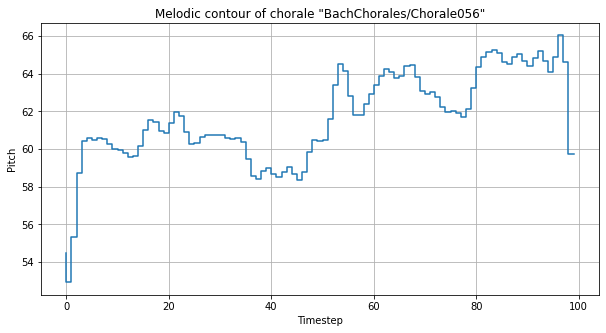

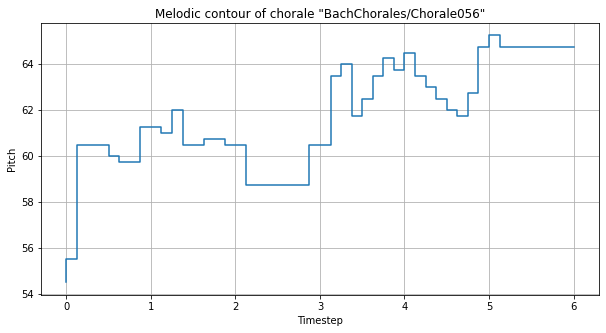

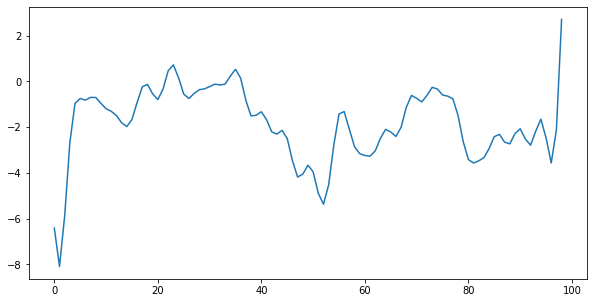

In [368]:
# plt.figure(figsize=(10, 5))
# plt.step(time_steps/max(time_steps)*99, pitches, '--', xnew/max(time_steps)*99, ynew, '-', time_steps_r,res, '-', )
# plt.show()

plt.figure(figsize=(10, 5))
plt.step(time_steps_r,res)
plt.xlabel('Timestep')
plt.ylabel('Pitch')
plt.title(f'Melodic contour of chorale "{random_piece}"')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.step(time_steps,pitches)
plt.xlabel('Timestep')
plt.ylabel('Pitch')
plt.title(f'Melodic contour of chorale "{random_piece}"')
plt.grid()
plt.show()
# # Number of sample points
# N = len(x)
# # Sample spacing (in units of time_unit)
# T = x[1].left

################################################################
N = len(res)
# Window the signal to reduce spectral leakage in the FFT (a good practise)
# window = signal.get_window('hann', N)

# Compute Fourier transform of signal
dctp = dct(res, norm='ortho', n=100)
# xf = rfftfreq(N, T)
# # Convert frequencies to units of cycles/whole note
# xf = xf/time_unit
# # Convert Fourier output to real-valued amplitudes
# amplitudes = np.abs(yf)

# # Find significant peaks (using min distance between neighbouring peaks)
# peaks, _ = find_peaks(amplitudes, distance=N*.07)
pitc = idct(dctp[1:], norm='ortho')
plt.figure(figsize=(10, 5))
plt.plot(pitc)